In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import scipy
from scipy.stats import zscore

from audio_utils import downsampleLabels, extractMelSpecs, windowEEG, stackFeatures

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions.normal import Normal

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn import metrics
simplefilter("ignore", category=ConvergenceWarning)

from model import EegDataset


In [2]:
path = Path('sentences_data/sentences/')
outPath = Path('./eeg/')
i=0
channels_to_skip = ['MKR1+', 'MKR2+', 'EKG+']
for file in path.rglob('*sentences.xdf'):
    if i == 1:
         break
    
    
    patient_id, session_id = file.name.split("_")[:2]
    print(f"Patient ID: {patient_id}, session: {session_id}")
    eeg_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_sEEG.npy")
    audio_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_audio.npy")
    ch_names = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_channelNames.npy")
    sentences_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences.npy")
    
    channels_to_skip_idx = [np.where(ch==ch_names)[0][0] for ch in channels_to_skip]
    eeg_ts = np.delete(eeg_ts, channels_to_skip_idx, axis=1)
    i=+1

Patient ID: p00, session: ses1


In [3]:
winL = 0.05
frameshift = 0.01
modelOrder = 4
stepSize = 5

audio_sr = 48000
eeg_sr = 1024

#Extract HG features
eeg = windowEEG(eeg_ts,eeg_sr, windowLength=winL,frameshift=frameshift)

# Process Audio
target_SR = 16000
audio = scipy.signal.decimate(audio_ts, int(audio_sr / target_SR))
audio_sr = target_SR
scaled = np.int16(audio/np.max(np.abs(audio)) * 32767) # stanmdard waveformat 

#Extract spectrogram
melSpec = extractMelSpecs(scaled,audio_sr,windowLength=winL,frameshift=frameshift)

#Align to EEG features
sentences = downsampleLabels(sentences_ts, eeg_sr, windowLength=winL, frameshift=frameshift)
sentences = sentences[modelOrder*stepSize:sentences.shape[0]-modelOrder*stepSize]
melSpec = melSpec[modelOrder*stepSize:melSpec.shape[0]-modelOrder*stepSize,:]

#adjust length (differences might occur due to rounding in the number of windows)
if melSpec.shape[0]!=eeg.shape[0]:
    tLen = np.min([melSpec.shape[0],eeg.shape[0]])
    melSpec = melSpec[:tLen,:]
    eeg = eeg[:tLen,:]

labels = np.array([0 if len(sent.decode('UTF-8')) == 0 else 1 for sent in sentences])

print(eeg.shape)
print(labels.shape)
print(melSpec.shape)

(50001, 51, 107)
(50001,)
(50001, 23)


In [96]:
class EEG_net(nn.Module):
  def __init__(self, ch_n):
    super(EEG_net, self).__init__()

    self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, kernel_size=(1,5), stride=1, padding="valid"),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.Conv2d(in_channels=15, out_channels=30, kernel_size=(ch_n,5), stride=1, padding="valid"),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            
        )

    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=30, out_channels=15, kernel_size=(ch_n,5), stride=1),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=15, out_channels=1, kernel_size=(1,5), stride=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [113]:
class VAE(nn.Module):
  def __init__(self, ch_n):
    super(VAE, self).__init__()

    self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, kernel_size=(1,5), stride=1, padding="valid"),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Conv2d(in_channels=15, out_channels=30, kernel_size=(ch_n,5), stride=1, padding="valid"),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            # nn.Dropout(0.1),
            # nn.ELU(),

        )

    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=30, out_channels=15, kernel_size=(ch_n,5), stride=1),
            # nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.ConvTranspose2d(in_channels=15, out_channels=1, kernel_size=(1,5), stride=1),
            # nn.BatchNorm2d(1),
            # nn.Linear(),
            )
    
    self.flatten = nn.Flatten()
    self.linear_dec = nn.Linear(50, 1290)
    
    self.fc_mu = nn.Linear(1290, 50)
    self.fc_var = nn.Linear(1290, 50)

  def encode(self, x):
    x = self.encoder(x)
    x_flat = self.flatten(x)
    mu = self.fc_mu(x_flat)
    log_var = self.fc_var(x_flat)
    z = self.reparameterize(mu, log_var)
    return mu, log_var, z
  
  def decode(self, z):
    z = self.linear_dec(z)
    z = z.reshape(z.shape[0], 30, 1, 43)
    x = self.decoder(z)
    return x
  
  def reparameterize(self, mu, logvar):
    
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = eps.mul(std).add_(mu)
    
    return z
  
  def forward(self, x):
    mu, log_var, z = self.encode(x)
    x = self.decode(z)
    return x, mu, log_var

In [6]:
n_batches = 1024

X_train, X_test, y_train, y_test = train_test_split(zscore(eeg, axis=1), labels, test_size=0.10, shuffle=True)

training_dataset = EegDataset(X_train, y_train)
testing_dataset = EegDataset(X_test, y_test)

training_dataloader = DataLoader(dataset=training_dataset, batch_size=n_batches, shuffle=False)
testing_dataloader = DataLoader(dataset=testing_dataset, batch_size=n_batches, shuffle=False)

In [114]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Model Initialization

autoencoder = VAE(ch_n=training_dataset.eeg_tensor.shape[2])
autoencoder = autoencoder.to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr = 1e-3)

model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

Device: cuda:0
676721


In [115]:
torch.cuda.empty_cache()

In [116]:
def loss_fn(X_rec, X_batch, mu, logvar):
    MSE = F.mse_loss(X_rec, X_batch)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + (1*KLD), MSE, KLD

n_epochs = 10
epoch_loss = []

for epoch in range(n_epochs):
    autoencoder.train()
    running_loss_arr = []
    running_loss = 0
    training_loop = tqdm(enumerate(training_dataloader), total=len(training_dataloader), leave=False)
    for batch_idx, (X_batch, _) in training_loop:

        X_batch = X_batch.permute(0,2,1)[:,None,:,:] # add depth
        X_batch = X_batch.to(device)
        # X_rec = autoencoder(X_batch)
        X_rec, mean, log_var = autoencoder(X_batch)

        # loss = loss_function(X_rec, X_batch)
        loss, mse, kld = loss_fn(X_batch, X_rec, mean, log_var)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss_arr.append(loss.item())
        
        running_loss += loss.item() * X_batch.shape[0]
        
        # update progress bar
        training_loop.set_description(f"Epoch {epoch+1}/{n_epochs}")
        training_loop.set_postfix(loss=loss.item())
    epoch_loss.append(round(running_loss / n_batches,2))


<Axes: >

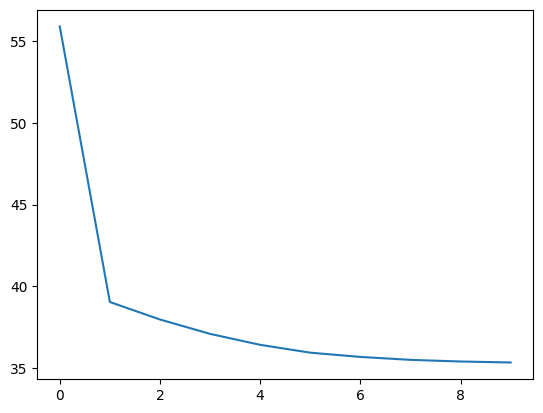

In [117]:
sns.lineplot(epoch_loss)

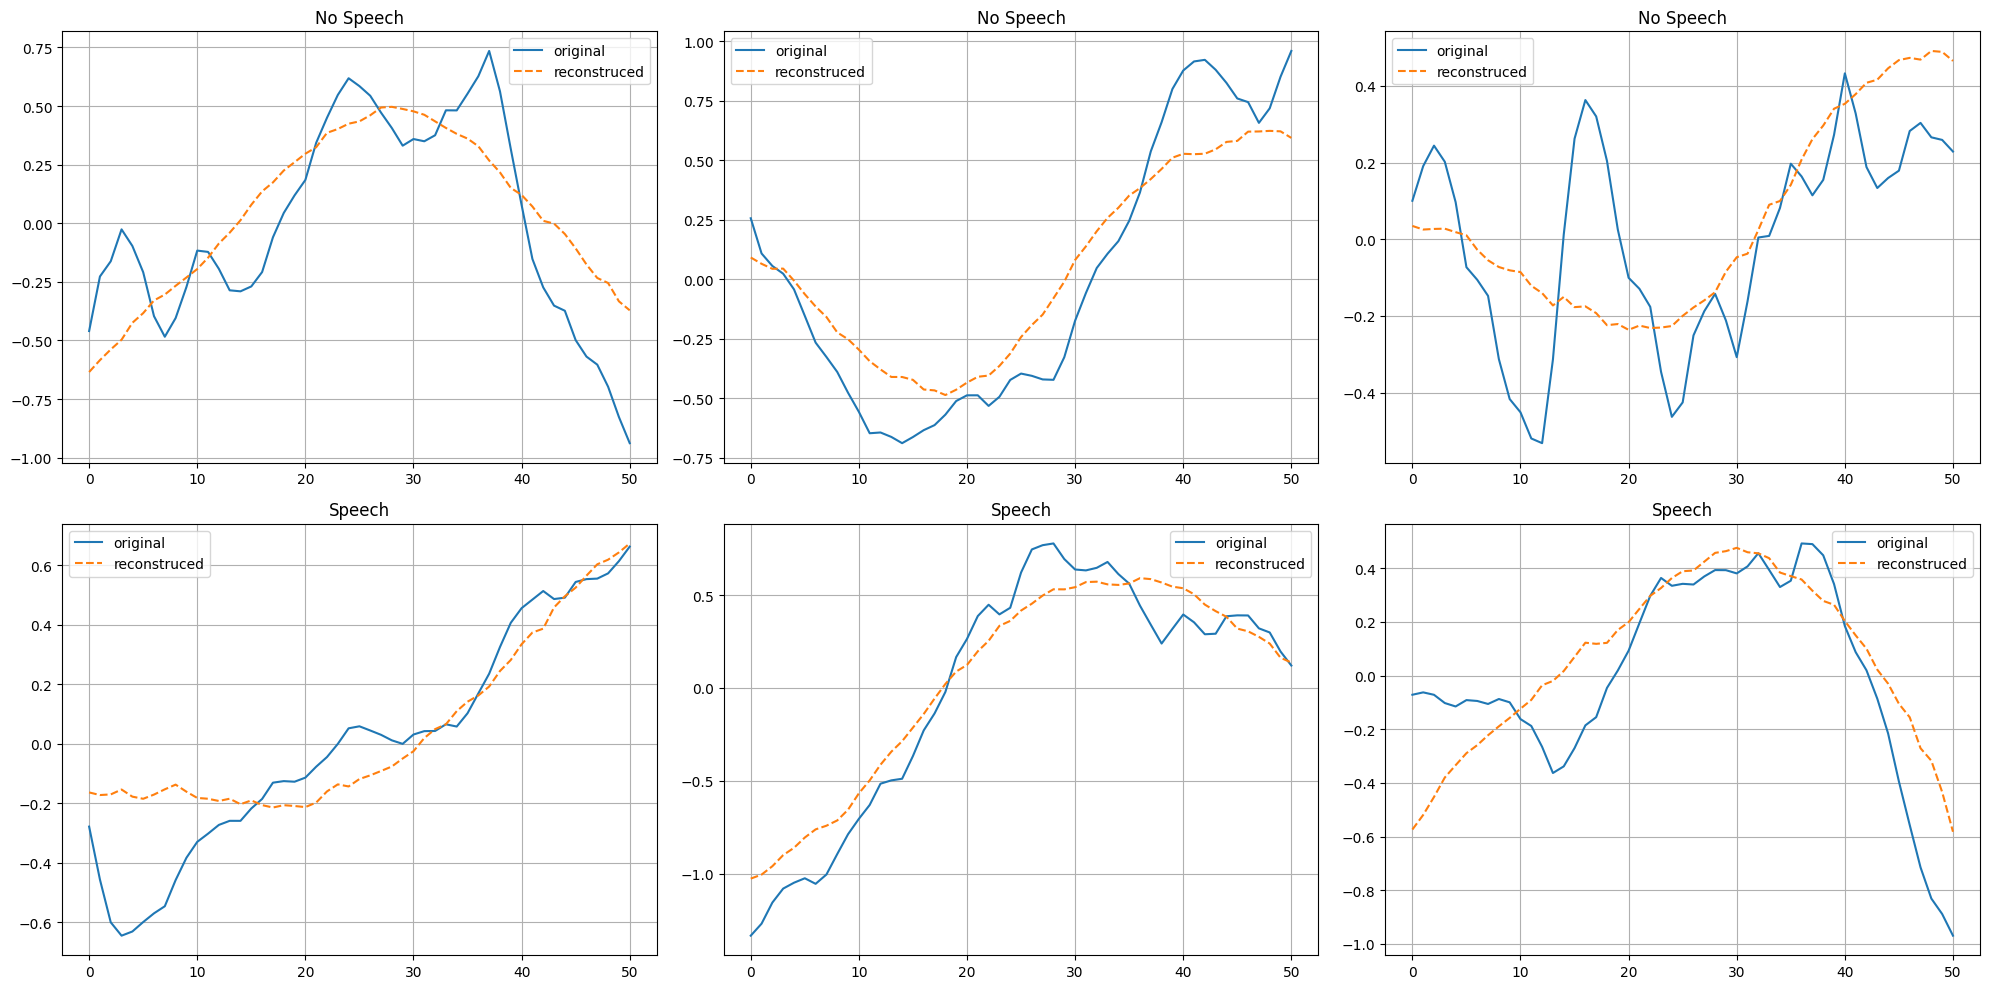

In [118]:
y_rest = np.random.choice(np.where(y_test==0)[0],3)
y_active = np.random.choice(np.where(y_test==1)[0],3)

X_test = testing_dataset.eeg_tensor.permute(0,2,1)[:,None,:,:]
autoencoder.to("cpu")
autoencoder.eval()
with torch.no_grad():
    X_reconstruction = autoencoder(X_test)[0].detach().numpy()

X_test_mean = X_test.mean(2).squeeze(1)
X_reconstruction_mean = X_reconstruction.mean(2).squeeze(1)

fig, axs = plt.subplots(2,3,figsize=(20,10),tight_layout=True)

for ax_idx, rest_idx in enumerate(y_rest):
    sns.lineplot(X_test_mean[rest_idx], label="original", ax=axs[0][ax_idx]);
    sns.lineplot(X_reconstruction_mean[rest_idx], label="reconstruced", ax=axs[0][ax_idx], linestyle='--');
    axs[0][ax_idx].set_title("No Speech")
    axs[0][ax_idx].grid()

for ax_idx, act_idx in enumerate(y_active):
    sns.lineplot(X_test_mean[act_idx], label="original", ax=axs[1][ax_idx]);
    sns.lineplot(X_reconstruction_mean[act_idx], label="reconstruced", ax=axs[1][ax_idx], linestyle='--');
    axs[1][ax_idx].set_title("Speech")
    axs[1][ax_idx].grid()

## No dimensionality reduction

torch.Size([5001, 107])

Class 0 F1: 0.21
Average F1: 0.68
Overall Accuracy: 0.69

Class 0 F1: 0.21
Average F1: 0.68
Overall Accuracy: 0.69

Class 0 F1: 0.17
Average F1: 0.67
Overall Accuracy: 0.68

Class 0 F1: 0.23
Average F1: 0.68
Overall Accuracy: 0.68

Class 0 F1: 0.18
Average F1: 0.67
Overall Accuracy: 0.68


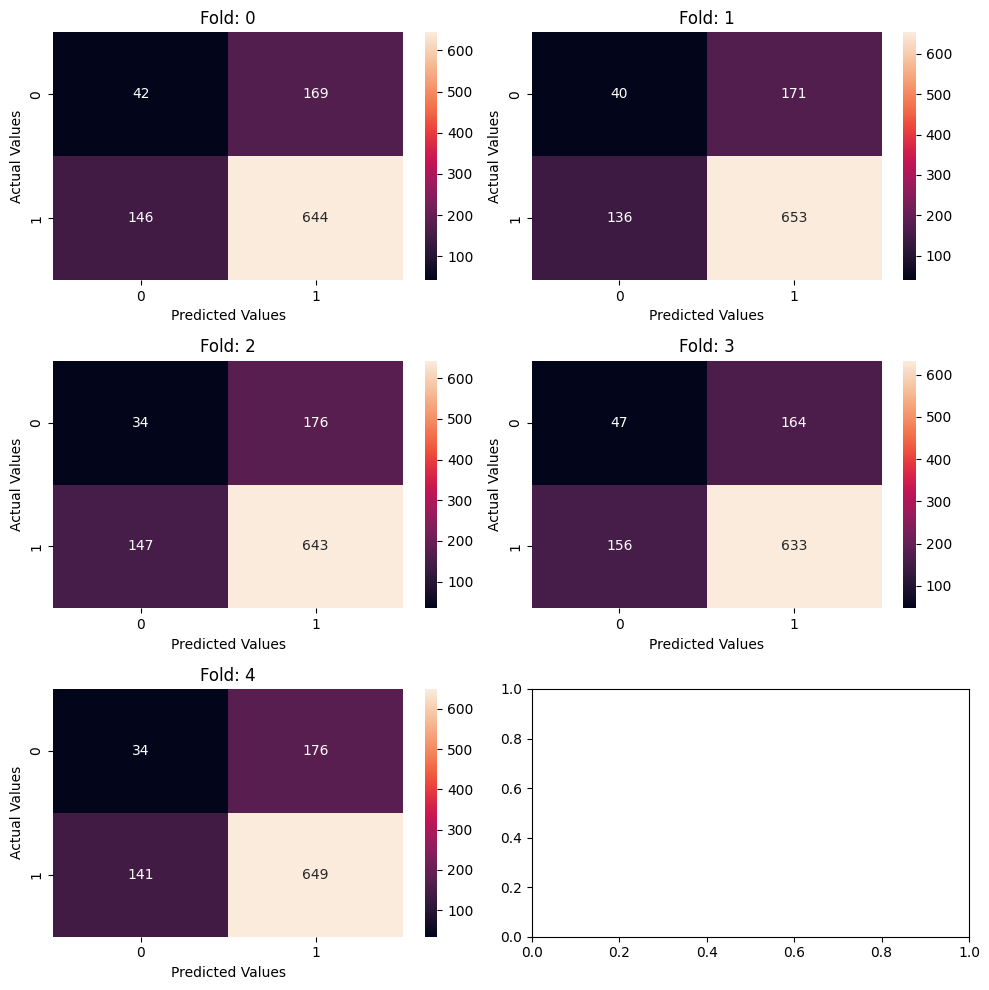

In [60]:
data = testing_dataset.eeg_tensor.permute(0,2,1).mean(2)
print(data.shape)

nfolds = 5
kf = KFold(nfolds, shuffle=False)
fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data)):
    
    # create training and testing datasets
    X_train = zscore(data[train, :], axis=1)
    X_test = zscore(data[test, :], axis=1)

    clf = svm.SVC(class_weight="balanced").fit(X_train, labels[train])

    y_pred = clf.predict(X_test)
    f1_negative = round(f1_score(labels[test], y_pred, pos_label=0),2) 
    f1_avg = round(f1_score(labels[test], y_pred, average="weighted"),2)
    acc = round(accuracy_score(labels[test], y_pred),2)
    
    print(f"\nClass 0 F1: {f1_negative}\nAverage F1: {f1_avg}\nOverall Accuracy: {acc}")
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")

## PCA

torch.Size([5001, 107])

Class 0 F1: 0.23
Average F1: 0.65
Overall Accuracy: 0.64

Class 0 F1: 0.29
Average F1: 0.64
Overall Accuracy: 0.61

Class 0 F1: 0.22
Average F1: 0.61
Overall Accuracy: 0.58

Class 0 F1: 0.23
Average F1: 0.62
Overall Accuracy: 0.59

Class 0 F1: 0.25
Average F1: 0.64
Overall Accuracy: 0.62


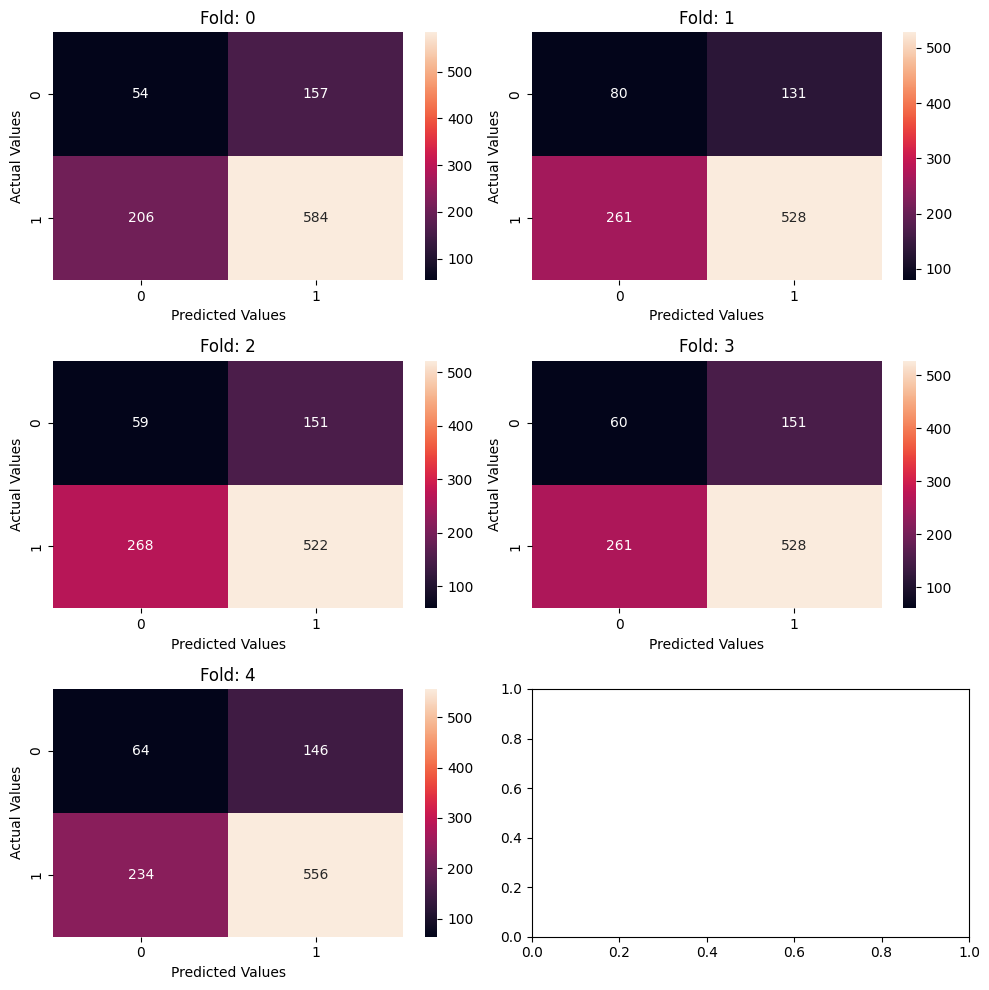

In [61]:
data = testing_dataset.eeg_tensor.permute(0,2,1).mean(2)
print(data.shape)

pca = PCA()
numComps = 50

nfolds = 5
kf = KFold(nfolds, shuffle=False)

fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data)):
    
    # create training and testing datasets
    X_train = zscore(data[train, :], axis=1)
    X_test = zscore(data[test, :], axis=1)

    #Fit PCA to training data
    pca.fit(X_train)

    #Get percentage of explained variance by selected components
    # print(np.sum(pca.explained_variance_ratio_[:numComps]))

    #Tranform data into component space
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    clf = svm.SVC(class_weight="balanced").fit(X_train, labels[train])

    y_pred = clf.predict(X_test)

    f1_negative = round(f1_score(labels[test], y_pred, pos_label=0),2) 
    f1_avg = round(f1_score(labels[test], y_pred, average="weighted"),2)
    acc = round(accuracy_score(labels[test], y_pred),2)
    
    print(f"\nClass 0 F1: {f1_negative}\nAverage F1: {f1_avg}\nOverall Accuracy: {acc}")
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")


## Dimensionality reduction

In [119]:
autoencoder.eval()
data = testing_dataset.eeg_tensor.permute(0,2,1)[:,None,:,:]

with torch.no_grad():
    data_encoded = autoencoder.encoder(data)

print(data_encoded.shape)    
data_encoded = data_encoded.mean(1).view(data_encoded.size(0),-1)
print(data_encoded.shape)    


torch.Size([5001, 30, 1, 43])
torch.Size([5001, 43])



Class 0 F1: 0.29
Average F1: 0.51
Overall Accuracy: 0.46

Class 0 F1: 0.3
Average F1: 0.59
Overall Accuracy: 0.55

Class 0 F1: 0.29
Average F1: 0.53
Overall Accuracy: 0.48

Class 0 F1: 0.3
Average F1: 0.57
Overall Accuracy: 0.53

Class 0 F1: 0.32
Average F1: 0.59
Overall Accuracy: 0.55


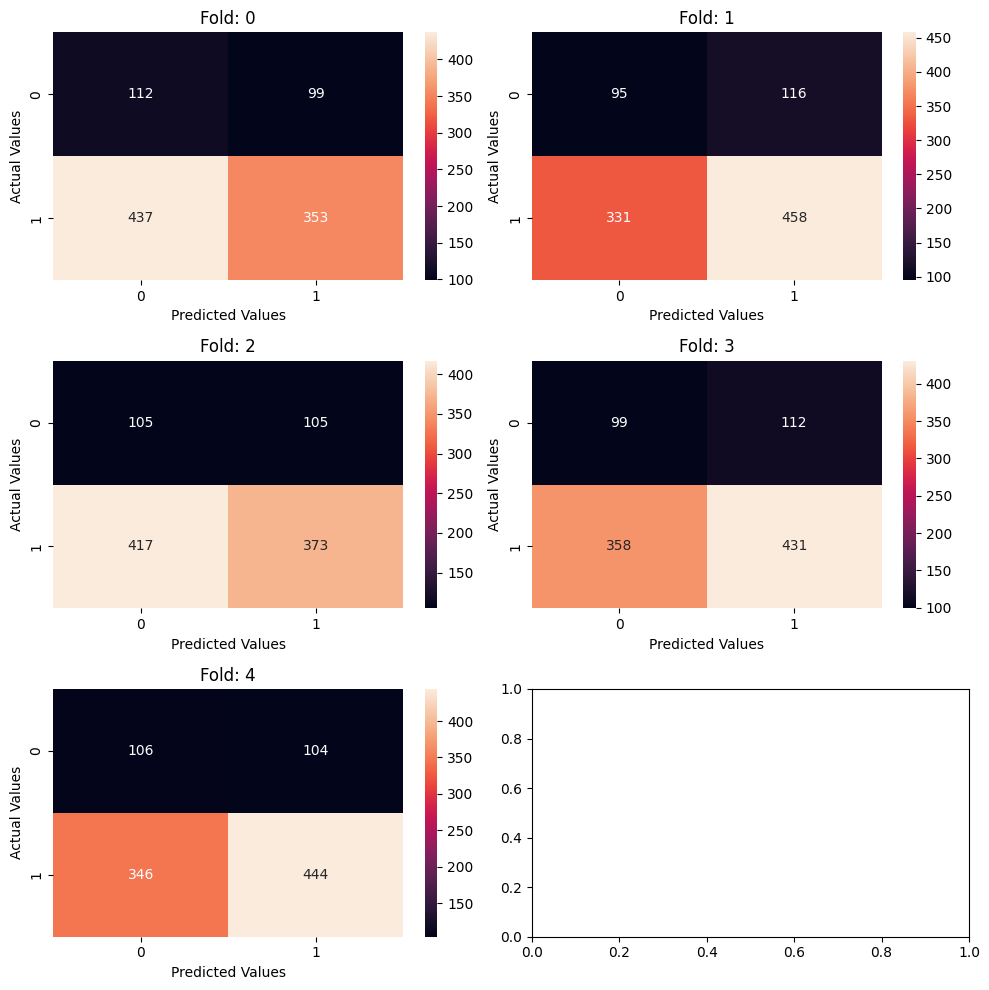

In [120]:
nfolds = 5
kf = KFold(nfolds, shuffle=False)

fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data_encoded)):
    
    # create training and testing datasets
    X_train = data_encoded[train, :]
    X_test = data_encoded[test, :]

    clf = svm.SVC(class_weight="balanced").fit(X_train, labels[train])

    y_pred = clf.predict(X_test)
    f1_negative = round(f1_score(labels[test], y_pred, pos_label=0),2) 
    f1_avg = round(f1_score(labels[test], y_pred, average="weighted"),2)
    acc = round(accuracy_score(labels[test], y_pred),2)
    
    print(f"\nClass 0 F1: {f1_negative}\nAverage F1: {f1_avg}\nOverall Accuracy: {acc}")
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")


In [121]:
def calculate_output_length(length_in, kernel_size, stride=1, padding=0, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                groups=in_channels, bias=bias, padding=1)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

c = 107
l = 51

f1 = 25
f2 = 50
d  = 10

input = torch.rand(1024,1,c,l)
print(input.shape)

conv_lay_1 = nn.Conv2d(in_channels=1,out_channels=f1,kernel_size=(1,5),stride=1, padding="valid")
output_1 = conv_lay_1(input)
print(output_1.shape)

conv_lay_2 = nn.Conv2d(in_channels=f1, out_channels=f2,kernel_size=(c,1),stride=1, padding="valid")
output_2 = conv_lay_2(output_1)
print(output_2.shape)

avg_pool_lay = nn.AvgPool2d(kernel_size=(1,5))
output_3 = avg_pool_lay(output_2)
print(output_3.shape)

avg_pool_lay = nn.Upsample((1,47))
output_4 = avg_pool_lay(output_3)
print(output_4.shape)

# trans_conv_lay_1 = nn.ConvTranspose2d(in_channels=f2, out_channels=f1,kernel_size=(c,1),stride=1)
# output_3 = trans_conv_lay_1(output_2)
# print(output_3.shape)

# trans_conv_lay_2 = nn.ConvTranspose2d(in_channels=f1, out_channels=1, kernel_size=(1,5), stride=1)
# output_4 = trans_conv_lay_2(output_3)
# print(output_4.shape)


# conv_lay_3 = SeparableConv2d((f1*d), f2, (1,5))
# output_3 = conv_lay_3(output_2)
# print(output_3.shape)
# torch.cuda.empty_cache()

torch.Size([1024, 1, 107, 51])
torch.Size([1024, 25, 107, 47])
torch.Size([1024, 50, 1, 47])
torch.Size([1024, 50, 1, 9])
torch.Size([1024, 50, 1, 47])
